# Setting Up

## Setting Up Conda Environment

In [1]:
# conda create -n nlp2 python=3.10.*
# conda activate nlp2 
# conda install tensorflow
# conda install pandas
# conda install spacy
# conda install scikit-learn
# conda install imbalanced-learn
# conda install worldcloud
# conda install gensim

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import spacy
import string
import random

from wordcloud import WordCloud # type: ignore
import matplotlib.pyplot as plt # type: ignore
#! python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier

In [43]:
from spacy.lang.en.stop_words import STOP_WORDS

## Importing Data

In [4]:
df = pd.read_csv('C:/Users/HP/Documents/Projects/report assignment/Twitter_Data.csv')
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


## Data Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [6]:
df.category.value_counts()

category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64

In [7]:
print(df['clean_text'][19])
print(df['clean_text'][91])

didn’ write chowkidar does mean ’ anti modi try visit the plz not all who haven’ used are anti 
dont forget petrol prices have risen ₹ modi government when gulf prices were going down ाेशबचा 


In [8]:
any_nan_in_A = df['clean_text'].isna().any()
print(any_nan_in_A)

True


In [9]:
df['clean_text'] = df['clean_text'].fillna('')

In [10]:
df = df.dropna()

In [11]:
any_nan_in_A = df['category'].isna().any()
print(any_nan_in_A)

False


In [12]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)


# Applying helper functions
df1 = df.copy()
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_URL(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_emoji(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_html(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_punct(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_quotes(x))
df1['clean_text'] = df1['clean_text'].str.lower()


print(df1['clean_text'][19]),
print(df1['clean_text'][91])

didn write chowkidar does mean  anti modi try visit the plz not all who haven used are anti 
dont forget petrol prices have risen  modi government when gulf prices were going down  


### Reducing the Dataset Size

As the Dataset size is too large, we'll reduce the dataset size by dropping the neutral (0.0) sentiment score in our Dataset

In [13]:
df2 =df1.copy()
df2 = df1[df1.category != 0.0]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107760 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  107760 non-null  object 
 1   category    107760 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [14]:
df2 = df2.drop_duplicates(subset=['clean_text'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107635 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  107635 non-null  object 
 1   category    107635 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


Reduced the dataset Size by 34% approx.

In [15]:
df3 = df2.copy()
def clean_review_text(text):
  doc = nlp(text)
  tokens = [token.lemma_ for token in doc if not token.is_digit
            and not token.is_space]
  return " ".join(tokens)

df3['clean_text'] = df3["clean_text"].apply(clean_review_text)

print(df3['clean_text'][19]),
print(df3['clean_text'][91])

didn write chowkidar do mean anti modi try visit the plz not all who haven use be anti
do not forget petrol price have rise modi government when gulf price be go down


# Exploratary Data Analysis

In [16]:
df_test = df3.copy()
category = df_test['category']
mapped_labels = [0 if label == -1 else 1 for label in category]
df_test['category'] = mapped_labels
df_test.head()


,clean_text,category
0,when modi promise minimum government maximum g...,0
2,what do just say vote for modi welcome bjp tel...,1
3,ask his supporter prefix chowkidar their name ...,1
4,answer who among these the most powerful world...,1
8,with upcoming election india saga go important...,1


In [17]:
display(df_test.describe())

# Print the info
print(df_test.info())

,category
count,107635.000000
mean,0.670358
std,0.470085
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 107635 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  107635 non-null  object
 1   category    107635 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.5+ MB
None


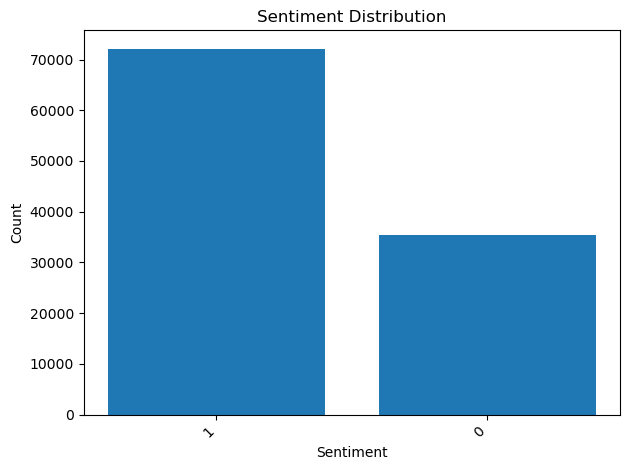

In [18]:
# Calculate sentiment counts
sentiment_counts = df_test['category'].value_counts()

# Get values for x-axis and y-axis
x = sentiment_counts.index.astype(str).to_list()  # Ensure string labels for x-axis
y = sentiment_counts.values.tolist()

# Create the bar chart
plt.bar(x, y)

# Customize the plot
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adjust layout for better visibility
plt.tight_layout()

# Display the plot
plt.show()

**Inference**

Positive data is the largest then neutral and then negative.

Which means our data is not balanced. We'll keep that in my mind when we'll train and test our data.

In [19]:
df4 = df_test.copy()
df4['word_count'] = df_test['clean_text'].apply(lambda x : len(x.split()))
df4['char_count'] = df_test['clean_text'].apply(lambda x : len(x.replace(" ","")))
df4['word_density'] = df4['word_count'] / (df4['char_count'] + 1)

df4[['word_count', 'char_count', 'word_density']].head()

,word_count,char_count,word_density
0,33,165,0.198795
2,22,94,0.231579
3,34,168,0.201183
4,14,67,0.205882
8,24,124,0.192000


In [20]:
def plot_distribution_by_category(df, column, start, end, size, category_type):
    # Filter data based on category
    negative_df = df[df['category'] == 0]
    positive_df = df[df['category'] == 1]

    # Define bins for histogram
    bins = np.arange(start, end + size, size)

    # Create subplots with 1 row and 2 columns (for negative, positive)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # Adjust figure size as needed

    # Plot histograms for each category in separate subplots
    ax[0].hist(negative_df[column], bins=bins, color='orange', alpha=0.75)
    ax[0].set_title('Negative Reviews')
    ax[0].set_xlabel(f'Review Length {category_type}')
    ax[0].set_ylabel('Number of Reviews')

    ax[1].hist(positive_df[column], bins=bins, color='blue', alpha=0.75)
    ax[1].set_title('Positive Reviews')
    ax[1].set_xlabel(f'Review Length {category_type}')
    ax[1].set_ylabel('Number of Reviews')

    # Adjust layout to prevent overlap of labels
    plt.tight_layout()

    # Show plot
    plt.show()

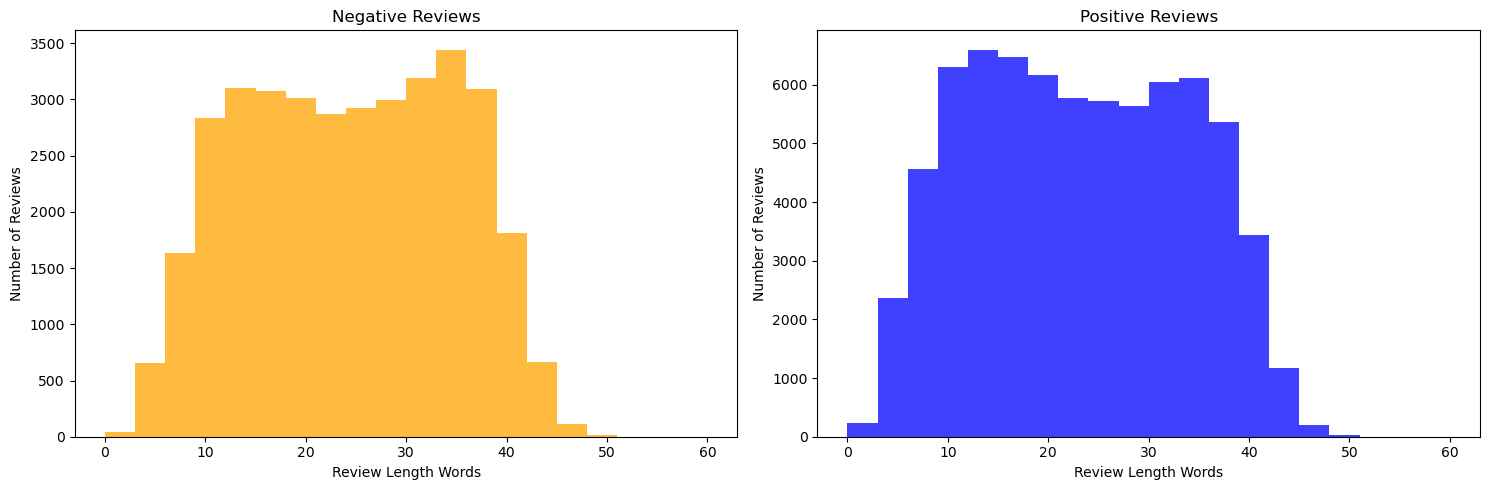

In [21]:
plot_distribution_by_category(df4, 'word_count', 0, 60, 3,'Words')

**Inference**

> Most tweets prefer to use less than 40 words to write a tweet.
>
> Generally, tweeters write about 10 - 37 words













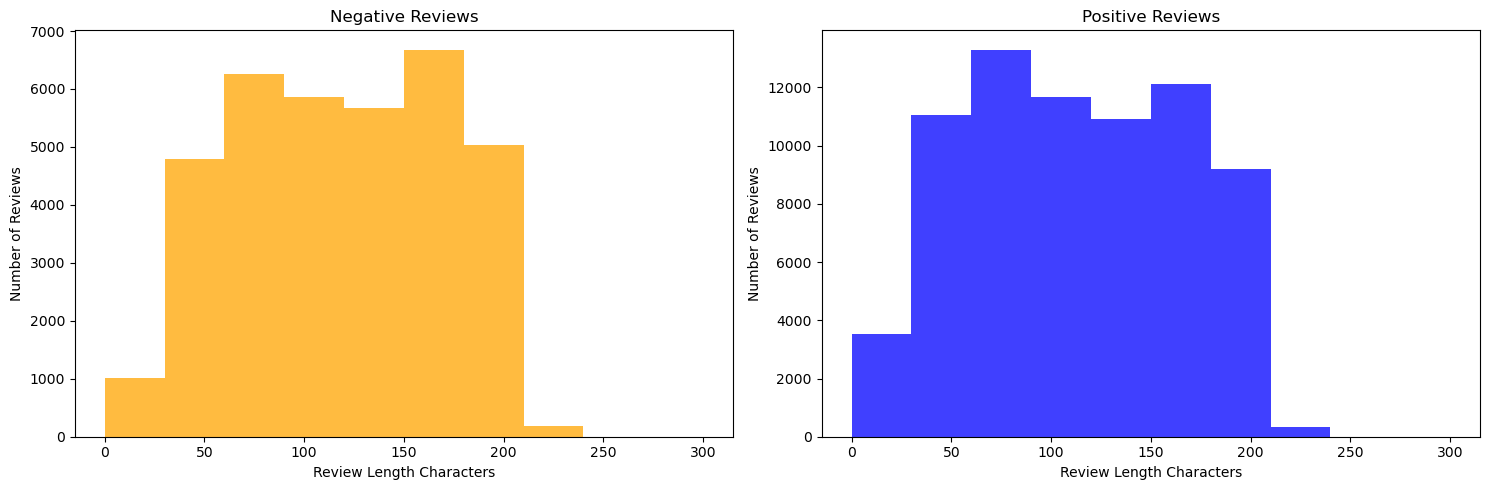

In [22]:
plot_distribution_by_category(df4, 'char_count', 0, 300, 30,'Characters')

**Inference**


> The twitter has a limitation of 280 words and yet tweeters use anywhere between 50-200 characters
>





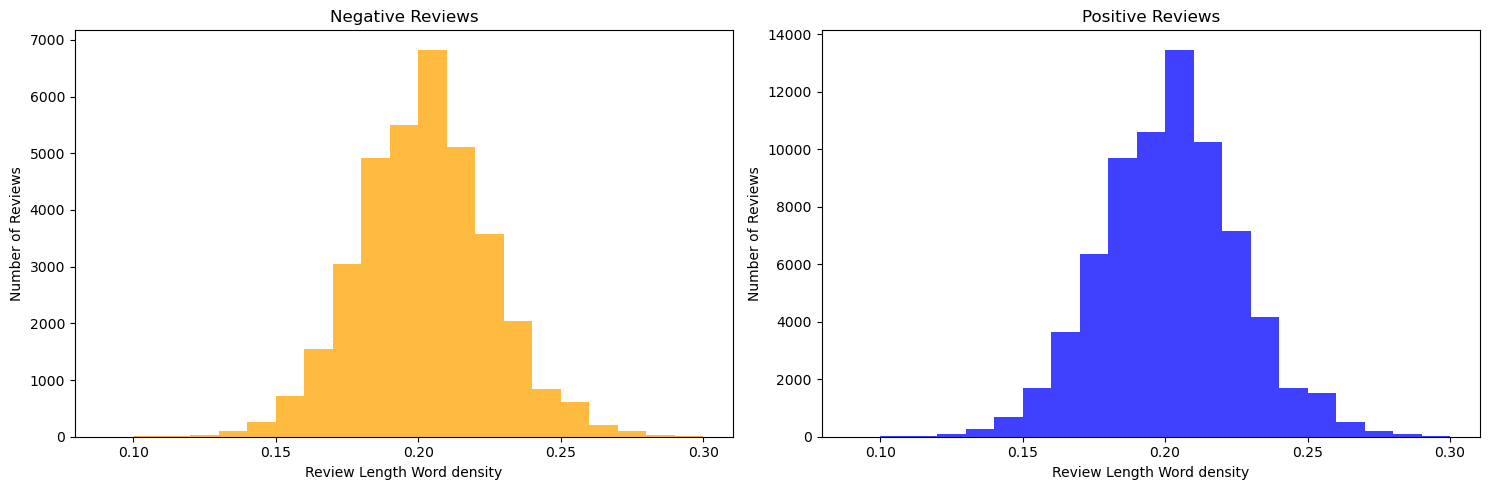

In [23]:
plot_distribution_by_category(df4,'word_density', 0.09, 0.3, .01,'Word density')

In [24]:
positive_tweets = df4[df4['category'] == 1.0]
negative_tweets = df4[df4['category'] == 0.0]

In [25]:
df4.head()

,clean_text,category,word_count,char_count,word_density
0,when modi promise minimum government maximum g...,0,33,165,0.198795
2,what do just say vote for modi welcome bjp tel...,1,22,94,0.231579
3,ask his supporter prefix chowkidar their name ...,1,34,168,0.201183
4,answer who among these the most powerful world...,1,14,67,0.205882
8,with upcoming election india saga go important...,1,24,124,0.192000


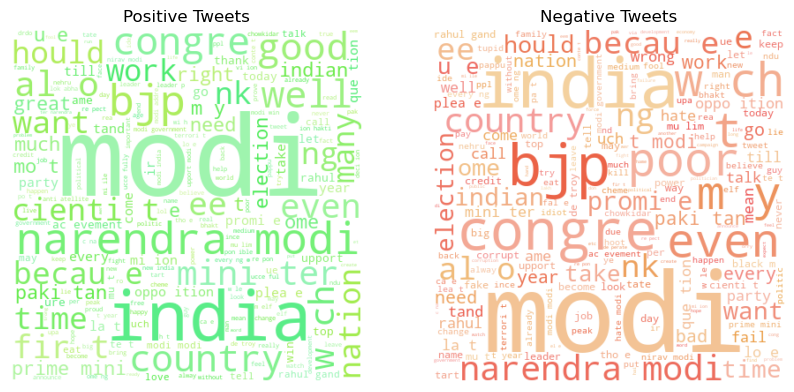

In [26]:
pos_text_cln = " ".join(positive_tweets.clean_text)
neg_text_cln = " ".join(negative_tweets.clean_text)

# replacing some most common words present in these texts
noise_words = ['will', 'make', 'people','say', 'vote', 'now', 'give',
               's', 'one', 'govt', 'thi', 'hi', 'ju', 'hi'
               ]
for noise in noise_words:
    pos_text_cln = pos_text_cln.lower().replace(noise," ")
    neg_text_cln = neg_text_cln.lower().replace(noise, " ")

def green_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl({:d}, 80%, {:d}%)'.format(random.randint(85, 140), random.randint(60, 80))

def red_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl({:d}, 80%, {:d}%)'.format(random.randint(0, 35), random.randint(60, 80))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 6])

wordcloud1 = WordCloud(background_color='white', height=400).generate(pos_text_cln)
ax1.imshow(wordcloud1.recolor(color_func=green_color, random_state=3),interpolation="bilinear")
ax1.axis('off');
ax1.set_title('Positive Tweets');

wordcloud2 = WordCloud(background_color='white', height=400).generate(neg_text_cln)
ax2.imshow(wordcloud2.recolor(color_func=red_color, random_state=3),interpolation="bilinear")
ax2.axis('off');
ax2.set_title('Negative Tweets');

Inference

> One thing is clear that our data comes largely from India as evident from WordCloud
>
> The topic also seems to be around politics primarily talking about 'bjp', 'congress' and 'modi'
>
> The word 'modi', prime minister of India, is used in every sentiment indicating both support and opposition for "Modi Government".

# Saving the dataset

In [27]:
df4.to_csv('refined_tweet_data.csv',encoding = 'utf-8-sig')

# Baseline Model

In [28]:
X = df4['clean_text']
Y = df4['category']

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify = Y,
                                                    random_state = 34)

In [30]:
#Initialize the tf-id vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')

#Using the vectorizer to fit on out training data and testing data
tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)

In [31]:
# Create a Majority Class Classifier
majority_classifier = DummyClassifier(strategy="most_frequent")
majority_classifier.fit(tfidf_train, Y_train)

# Predict the majority class for all instances in the test set
y_pred_majority = majority_classifier.predict(tfidf_test)

In [32]:
# Print classification report
print("\nClassification Report:\n")
print(classification_report(Y_test, y_pred_majority))


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7096
           1       0.67      1.00      0.80     14431

    accuracy                           0.67     21527
   macro avg       0.34      0.50      0.40     21527
weighted avg       0.45      0.67      0.54     21527



c:\Users\HP\anaconda3\envs\nlp2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\envs\nlp2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\envs\nlp2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Traditional Machine Learning Model

## Naive Bayes

In [33]:
# df4 = pd.read_csv('/content/refined_tweet_data.csv')

In [34]:
#Initialize the Multinomial Naive Bayes classifier
best_accuracy = 0
a = 0.1
while a <= 1:
  nb = MultinomialNB(alpha=a)

  #Fitting the model
  nb.fit(tfidf_train, Y_train)
  curr_accuracy = nb.score(tfidf_test, Y_test)
  print(f"Accuracy with alpha {a}: {curr_accuracy}")
  # Predict the labels
  if curr_accuracy > best_accuracy:
    best_accuracy = curr_accuracy
    y_pred = nb.predict(tfidf_test)
  a = a + 0.05

Accuracy with alpha 0.1: 0.766386398476332
Accuracy with alpha 0.15000000000000002: 0.7636921075858225
Accuracy with alpha 0.2: 0.7601616574534306
Accuracy with alpha 0.25: 0.7566776606122544
Accuracy with alpha 0.3: 0.7528684907325685
Accuracy with alpha 0.35: 0.749988386677196
Accuracy with alpha 0.39999999999999997: 0.7464114832535885
Accuracy with alpha 0.44999999999999996: 0.7424629535002555
Accuracy with alpha 0.49999999999999994: 0.7381892507084127
Accuracy with alpha 0.5499999999999999: 0.7347517071584522
Accuracy with alpha 0.6: 0.7310818971524132
Accuracy with alpha 0.65: 0.7276908068936684
Accuracy with alpha 0.7000000000000001: 0.7247177962558647
Accuracy with alpha 0.7500000000000001: 0.7209086263761788
Accuracy with alpha 0.8000000000000002: 0.717935615738375
Accuracy with alpha 0.8500000000000002: 0.71486969851814
Accuracy with alpha 0.9000000000000002: 0.7124541273749245
Accuracy with alpha 0.9500000000000003: 0.7091094904073953


### Evaluate Performance

In [35]:
# Print classification report
print("\nClassification Report:\n")
print(classification_report(Y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.38      0.52      7096
           1       0.76      0.96      0.85     14431

    accuracy                           0.77     21527
   macro avg       0.79      0.67      0.68     21527
weighted avg       0.78      0.77      0.74     21527



In [36]:
smote = SMOTE(random_state=42)
tfidf_train_oversample, Y_train = smote.fit_resample(tfidf_train, Y_train)

In [37]:
#Initialize the Multinomial Naive Bayes classifier
best_accuracy = 0
a = 0.1
while a <= 1:
  nb = MultinomialNB(alpha=a)

  #Fitting the model
  nb.fit(tfidf_train_oversample, Y_train)
  curr_accuracy = nb.score(tfidf_test, Y_test)
  print(f"Accuracy with alpha {a}: {curr_accuracy}")
  # Predict the labels
  if curr_accuracy > best_accuracy:
    best_accuracy = curr_accuracy
    y_pred = nb.predict(tfidf_test)
  a = a + 0.05

Accuracy with alpha 0.1: 0.7837134760997817
Accuracy with alpha 0.15000000000000002: 0.7880800854740558
Accuracy with alpha 0.2: 0.7924931481395456
Accuracy with alpha 0.25: 0.7949551725739769
Accuracy with alpha 0.3: 0.7970455706786825
Accuracy with alpha 0.35: 0.7984856227063687
Accuracy with alpha 0.39999999999999997: 0.8006224741022901
Accuracy with alpha 0.44999999999999996: 0.8019231662563293
Accuracy with alpha 0.49999999999999994: 0.8034561248664468
Accuracy with alpha 0.5499999999999999: 0.8047568170204858
Accuracy with alpha 0.6: 0.8060110558833093
Accuracy with alpha 0.65: 0.8077762809495053
Accuracy with alpha 0.7000000000000001: 0.8092163329771914
Accuracy with alpha 0.7500000000000001: 0.8105170251312306
Accuracy with alpha 0.8000000000000002: 0.8118641705764853
Accuracy with alpha 0.8500000000000002: 0.8131184094393088
Accuracy with alpha 0.9000000000000002: 0.8140939285548381
Accuracy with alpha 0.9500000000000003: 0.8147907279230734


In [38]:
# Print classification report
print("\nClassification Report:\n")
print(classification_report(Y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.82      0.75      7096
           1       0.90      0.81      0.85     14431

    accuracy                           0.81     21527
   macro avg       0.79      0.82      0.80     21527
weighted avg       0.83      0.81      0.82     21527



**Inference:**

Based on the evaluation metrics, the text classification model demonstrates a GOOD overall performance. It achieves an accuracy of almost 83%, with somewhat imbalanced precision and precise recall for both classes. The F1-score further support this conclusion.

## Logistic Regression

In [39]:
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(tfidf_train_oversample, Y_train)

logistic_prediction = logistic_regression.predict(tfidf_test)
logistic_accuracy = accuracy_score(Y_test, logistic_prediction)
print(f"Accuracy: {logistic_accuracy}")

Accuracy: 0.9056998188321642


### Evaluate Performance

In [40]:
# Print the Classification Report
cr = classification_report(Y_test, logistic_prediction)
print("\n\nClassification Report\n")
print(cr)



Classification Report

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      7096
           1       0.94      0.92      0.93     14431

    accuracy                           0.91     21527
   macro avg       0.89      0.90      0.89     21527
weighted avg       0.91      0.91      0.91     21527



**Inference:**

These metrics suggest that the text classification model demonstrates great overall performance with an accuracy of 93% in classifying text data. It can effectively identify positive and negative tweets with a balanced accuracy and has a good ability to differentiate between the classes.

In [49]:
# Text cleaning function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text


# Remove stopwords using SpaCy
def remove_stopwords(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.text not in STOP_WORDS])

# Function to predict sentiment of a new tweet
def predict_sentiment(tweet):
    clean_tweet = clean_text(tweet)
    clean_tweet = remove_stopwords(clean_tweet)
    tweet_tfidf = vectorizer.transform([clean_tweet])
    return tweet_tfidf

# Test the function
new_tweet = "I don't know what to say!"
print(f'Tweet: {new_tweet}')
cleaned_tweet = predict_sentiment(new_tweet)
print(f'According to Naive Bayes Sentiment: {nb.predict(cleaned_tweet)[0]}')
print(f'According to Logistic Regression Sentiment: {logistic_regression.predict(cleaned_tweet)[0]}')


Tweet: I don't know what to say!
According to Naive Bayes Sentiment: 1
According to Logistic Regression Sentiment: 0
